# Optimization for data science

Members: Karim Hamdar (2092041), Davide Christian Mancosu Bustos (2089208), Luca Tusini (2092227)

#**TOY Dataset**

# **Preliminary steps**

In [1]:
#!conda install --yes xlrd

In [2]:
# libraries
import xlrd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import time

In [3]:
# set the seed to replicate the results
np.random.seed(123)

In [4]:
# Constants
m, d, k = 1000, 1000, 50

# **First point**

Randomly generate a 1000x1000 matrix with entries from a N(0,1) distribution



In [ ]:
# randomly generate a 1000x1000 matrix with entries from a N(0,1) distribution
A = np.random.randn(m, d)
print(A)

[[-1.0856306   0.99734545  0.2829785  ... -0.90932702  0.47026375
  -1.11143045]
 [-0.74882747  0.56759473  0.71815054 ... -0.35929672 -1.60969508
   0.01357006]
 [-1.77422355 -1.20137731  1.09625679 ...  2.04043199  1.01591697
  -1.63378817]
 ...
 [-0.58293176 -0.39992967 -0.66714316 ... -0.84152302 -0.7138398
   0.24183884]
 [ 0.31359983 -0.2658506   0.32559755 ... -0.89330319  0.89285981
   1.21151471]
 [ 0.31397752  0.3933895  -0.81198728 ... -0.84768045 -0.73819061
  -1.29277267]]


# **Second point**

Generate $b_i\in{1,2,...,k},\ (k=50)$ by computing $AX+E$ with $X,E$ sampled from normal distribution $X\in R^{dxk}\ ,\ \ E\in R^{mxk}$ considering max index in the row as a class label.

In [ ]:
# Generate random matrices
X = np.random.randn(m, k)

# Generate random matrices
W = np.random.randn(d, k)
E = np.random.randn(m, k)

# Compute AX + E
AX_plus_E = np.dot(A, X) + E

# Find max index in each row
B = np.argmax(AX_plus_E, axis=1) # <-- range from 0 to 49

print("Class labels shape:", B.shape)
print("Class labels:", B[:10])

Class labels shape: (1000,)
Class labels: [ 1  6 32 10 26 45 27  4 23 37]


We want to minimize the function:

$$f(x)= \underset{x\epsilon R^{dxk}}{min}{\sum_{i=1}^{m}\left[{-x}{b_i}^Ta_i+\log{\left(\sum_{c=1}^{k}e^{\left(x_c^Ta_i\right)}\right)}\right]}$$

In [ ]:
# Convert a vector of random numbers into a one-hot encoding version.
def one_hot_encode(vector):
    unique_values = np.unique(vector)
    num_unique = len(unique_values)
    num_elements = len(vector)

    one_hot = np.zeros((num_elements, num_unique))

    for i, value in enumerate(vector):
        index = np.where(unique_values == value)[0][0]
        one_hot[i, index] = 1

    return one_hot

# Function to compute negative log-likelihood
def loss(A, B, X):
    # NOTICE: B must be in one-hot encoding for
    loss = (np.trace(A @ X @ B.T) + np.sum(np.log(np.sum(np.exp(- np.dot(A, X)), axis=1))))
    return np.round(loss,2)

# Function to compute softmax row-wise of an input matrix
def softmax(matrix):
    return np.array([np.exp(row) / sum(np.exp(row)) for row in matrix]).reshape(matrix.shape)

# Function to compute the gradient
def gradient(A, B, X):
    # NOTICE: B must be in one-hot encoding for
    P = softmax(- np.dot(A, X))
    gd = (A.T @ (B - P))
    return gd

# Function to compute the gradient of just one column of the parameters
def gradient_col(A, B, X, index):
    # NOTICE: B must be in one-hot encoding for
    P = softmax(- np.dot(A, X))
    gd = (A.T @ (B[:,index] - P[:,index]))
    return gd

# Function to compute the score accuracy
def accuracy(A, X, B):
    acc = np.sum(np.argmax(softmax(-np.dot(A, X)), axis=1) == B )/A.shape[0]*100
    return np.round(acc,1)

# **Third point**

Solve the problem with:
1.   Gradient Descent
2.   BCGD with randomized rule
3.   BCGD with gauss-southwell rule

The partial derivative of $f(x)$ is:

$$\frac{\partial f(x)}{\partial X_{j_c}}=-\sum_{i=1}^{m}{a_{ij}\left[I\left(b_i=c\right)-\frac{e^{{x_c}^T}a_i}{\sum_{c'=1}^{k}{e^{{x_{c'}}^T}a_i}}\right]}$$

In [ ]:
def gradient_descent(A, B, alpha, max_iter, threshold):

    B_onehot = one_hot_encode(B)

    # different ways to initialize the parameters
    X = np.zeros((A.shape[1], B_onehot.shape[1]))
    # X = np.random.rand(A.shape[1], B_onehot.shape[1])
    # X = np.random.normal(1, 1, (A.shape[1], B_onehot.shape[1]))

    step = 0
    step_lst = []
    loss_lst = []
    acc_lst = []

    init_time = time.time()
    ticks_gd = [] # CPU time

    # print(f"Initial accuracy: {accuracy(A,X,B)}%\n")

    while step < max_iter:
        step += 1
        step_lst.append(step)

        X -= alpha * gradient(A, B_onehot, X)

        loss_lst.append(loss(A, B_onehot, X))

        acc_lst.append(accuracy(A, X, B))

        print(f"Step: {step} ------------ Loss: {loss_lst[-1]} ------------ Accuracy: {acc_lst[-1]}%")
        ticks_gd.append(time.time() - init_time)

        # Stopping condition over accuracy
        if acc_lst[-1] >= threshold:
            print(f"\nStopping Condition reached at iteration {step}: accuracy = {acc_lst[-1]}%")
            break

    df = pd.DataFrame({
        'step': step_lst,
        'loss': loss_lst,
        'accuracy': acc_lst,
        'CPU': ticks_gd
    })

    return df, X

In [ ]:
def R_bcgd(A, B, alpha, max_iter, threshold, block_size=1):

    B_onehot = one_hot_encode(B)

    # different ways to initialize the parameters
    X = np.zeros((A.shape[1], B_onehot.shape[1]))
    # X = np.random.rand(A.shape[1], B_onehot.shape[1])
    # X = np.random.normal(1, 1, (A.shape[1], B_onehot.shape[1]))

    step = 0
    step_lst = []
    loss_lst = []
    acc_lst = []

    init_time = time.time()
    ticks_gd = [] # CPU time

    # print(f"Initial accuracy: {accuracy(A,X,B)}%\n")

    while step < max_iter:
        step += 1
        step_lst.append(step)

        # Choose block at random
        block_index = np.random.choice(X.shape[0], block_size, replace=False)
        # block_index = np.random.choice(X.shape[1], block_size, replace=False)

        X[block_index] -= alpha * gradient(A, B_onehot, X)[block_index]
        # X[:,block_index] -= alpha * gradient_col(A, B_onehot, X, block_index)

        loss_lst.append(loss(A, B_onehot, X))

        # predict to check accuracy
        acc_lst.append(accuracy(A,X,B))

        print(f"Step: {step} ------------ Loss: {loss_lst[-1]} ------------ Accuracy: {acc_lst[-1]}%")
        ticks_gd.append(time.time() - init_time)

        if acc_lst[-1] >= threshold:
            print(f"\nStopping Condition reached at iteration {step}: accuracy = {acc_lst[-1]}%")
            break

    df = pd.DataFrame({
        'step': step_lst,
        'loss': loss_lst,
        'accuracy': acc_lst,
        'CPU': ticks_gd
    })

    return df, X

In [ ]:
def GS_bcgd(A, B, alpha, max_iter, threshold, block_size=1):

    B_onehot = one_hot_encode(B)

    # different ways to initialize the parameters
    X = np.zeros((A.shape[1], B_onehot.shape[1]))
    # X = np.random.rand(A.shape[1], B_onehot.shape[1])
    # X = np.random.normal(1, 1, (A.shape[1], B_onehot.shape[1]))

    step = 0
    step_lst = []
    loss_lst = []
    acc_lst = []

    init_time = time.time()
    ticks_gd = [] # CPU time

    # print(f"Initial accuracy: {accuracy(A,X,B)}%\n")

    while step < max_iter:
        step += 1
        step_lst.append(step)

        norm = []

        # compute norm of each row (block)
        for block in gradient(A, B_onehot, X):
            norm.append(np.linalg.norm(block))

        # take max norm index
        block_index = np.argmax(norm)

        X[block_index] -= alpha * gradient(A, B_onehot, X)[block_index]

        loss_lst.append(loss(A, B_onehot, X))

        acc_lst.append(accuracy(A,X,B))

        print(f"Step: {step} ------------ Loss: {loss_lst[-1]} ------------ Accuracy: {acc_lst[-1]}%")
        ticks_gd.append(time.time() - init_time)

        if acc_lst[-1] >= threshold:
            print(f"\nStopping Condition reached at iteration {step}: accuracy = {acc_lst[-1]}%")
            break

    df = pd.DataFrame({
        'step': step_lst,
        'loss': loss_lst,
        'accuracy': acc_lst,
        'CPU': ticks_gd
    })


    return df, X

In [ ]:
class Multiclass:

    def fit(self, A, B, type, alpha, max_iter, threshold):
        if type=="GD":
            self.loss_steps, self.X = gradient_descent(A, B, alpha, max_iter, threshold)

        elif type=="BCGD_R":
            self.loss_steps, self.X = R_bcgd(A, B, alpha, max_iter, threshold)

        elif type=="BCGD_GS":
            self.loss_steps, self.X = GS_bcgd(A, B, alpha, max_iter, threshold)

    def plot(self, w):
        if w == "Loss":
            return self.loss_steps.plot(
                x='step',
                y='loss',
                xlabel='Step',
                ylabel='Loss',
                color='orange',
                title='Iterations VS Loss')

        elif w == "Accuracy":
            return self.loss_steps.plot(
                x='step',
                y='accuracy',
                xlabel='Step',
                ylabel='Accuracy',
                color='orange',
                title='Iterations VS Accuracy')

        elif w == "CPU":
            return self.loss_steps.plot(
                x='CPU',
                y='accuracy',
                xlabel='CPU time',
                ylabel='Accuracy',
                title='CPU time VS Accuracy',
                color='orange',
                legend=False)

    def backup(self):
      return self.loss_steps

    def predict(self, H):
        Z = - H @ self.X
        P = softmax(Z)
        return np.argmax(P, axis=1)

In [ ]:
# Initialize the model
model = Multiclass()

**Perform classic Gradient Descent algorithm**

In [ ]:
start_time = time.time()
# fit model
model.fit(A, B, "GD", 0.01, 2000, 100)
end_time = time.time()

print(f"\n Time taken: {np.round(end_time - start_time,2)} seconds")

NameError: name 'B' is not defined

In [ ]:
# check how many matches comparing predicted value and actual value
np.sum(model.predict(A) == B)

In [ ]:
# Produce plots
args = ["Loss", "Accuracy", "CPU"]
for a in args: model.plot(a)

In [ ]:
# save the data for later comparison
df_gd = model.backup()

**Perform BCGD Randomized**

In [ ]:
start_time = time.time()
# fit model
model.fit(A, B, "BCGD_R", 0.01, 2000, 100)
end_time = time.time()

print(f"\n Time taken: {np.round(end_time - start_time,2)} seconds")

In [ ]:
# check how many matches comparing predicted value and actual value
np.sum(model.predict(A) == B)

In [ ]:
# Produce plots
args = ["Loss", "Accuracy", "CPU"]
for a in args: model.plot(a)

In [ ]:
# save the data for later comparison
df_random = model.backup()

**Perform BCGD with GS rule**

In [ ]:
start_time = time.time()
# fit model
model.fit(A, B, "BCGD_GS", 0.01, 2000, 100)
end_time = time.time()

print(f"\n Time taken: {np.round(end_time - start_time,2)} seconds")

In [ ]:
# check how many matches comparing predicted value and actual value
np.sum(model.predict(A) == B)

In [ ]:
# Produce plots
args = ["Loss", "Accuracy", "CPU"]
for a in args: model.plot(a)

In [ ]:
# save the data for later comparison
df_gs = model.backup()

# **1° Real dataset**

(https://archive.ics.uci.edu/dataset/602/dry+bean+dataset)

The dataset contains 13,611 observations, each with 17 features about dry beans, which are to be classified into one of seven classes.

## 1) Data Manipulation

In [5]:
# load the dataset
df = pd.read_excel("/content/Dry_Bean_Dataset.xlsx") #(13611, 17)
df.tail()

,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4,Class
13606,42097,759.696,288.721612,185.944705,1.552728,0.765002,42508,231.515799,0.714574,0.990331,0.916603,0.801865,0.006858,0.001749,0.642988,0.998385,DERMASON
13607,42101,757.499,281.576392,190.713136,1.476439,0.735702,42494,231.526798,0.799943,0.990752,0.922015,0.822252,0.006688,0.001886,0.676099,0.998219,DERMASON
13608,42139,759.321,281.539928,191.187979,1.472582,0.734065,42569,231.631261,0.729932,0.989899,0.918424,0.822730,0.006681,0.001888,0.676884,0.996767,DERMASON
13609,42147,763.779,283.382636,190.275731,1.489326,0.741055,42667,231.653248,0.705389,0.987813,0.907906,0.817457,0.006724,0.001852,0.668237,0.995222,DERMASON
13610,42159,772.237,295.142741,182.204716,1.619841,0.786693,42600,231.686223,0.788962,0.989648,0.888380,0.784997,0.007001,0.001640,0.616221,0.998180,DERMASON


In [ ]:
df.columns

Index(['Area', 'Perimeter', 'MajorAxisLength', 'MinorAxisLength',
       'AspectRation', 'Eccentricity', 'ConvexArea', 'EquivDiameter', 'Extent',
       'Solidity', 'roundness', 'Compactness', 'ShapeFactor1', 'ShapeFactor2',
       'ShapeFactor3', 'ShapeFactor4', 'Class'],
      dtype='object')

In [ ]:
# checking for missing values
print(f'Q: is there any missing value?  A: {df.isnull().any().any()}')

Q: is there any missing value?  A: False


In [ ]:
# labels (#7)
labels = df['Class'].unique().tolist()
labels

['SEKER', 'BARBUNYA', 'BOMBAY', 'CALI', 'HOROZ', 'SIRA', 'DERMASON']

In [ ]:
# check if dataset is balanced
df['Class'].value_counts() # frequencies

Class
DERMASON    3546
SIRA        2636
SEKER       2027
HOROZ       1928
CALI        1630
BARBUNYA    1322
BOMBAY       522
Name: count, dtype: int64

In [ ]:
# NOTICE: class are divided into block
df['Class']

0           SEKER
1           SEKER
2           SEKER
3           SEKER
4           SEKER
           ...   
13606    DERMASON
13607    DERMASON
13608    DERMASON
13609    DERMASON
13610    DERMASON
Name: Class, Length: 13611, dtype: object

In [ ]:
# shuffle rows to prevent imbalanced splitting
df = df.sample(frac=1).reset_index(drop=True)
df['Class']

0           HOROZ
1            CALI
2        BARBUNYA
3           SEKER
4            SIRA
           ...   
13606       SEKER
13607    DERMASON
13608       SEKER
13609    DERMASON
13610        SIRA
Name: Class, Length: 13611, dtype: object

In [ ]:
# reduce the dataset
df = df[:9000]

In [ ]:
# make labels as numbers
Y = df["Class"]

# Step 1: Create a mapping of each unique word to a unique number
word_to_number = {word: index for index, word in enumerate(labels)}

# Step 2: Replace each word in the original list with its corresponding number
Y_as_number = [word_to_number[word] for word in Y]

Y = np.asarray(Y_as_number)
print(Y[:12])

[4 3 1 0 5 4 0 5 5 4 2 5]


In [ ]:
# codex list
word_to_number

{'SEKER': 0,
 'BARBUNYA': 1,
 'BOMBAY': 2,
 'CALI': 3,
 'HOROZ': 4,
 'SIRA': 5,
 'DERMASON': 6}

In [ ]:
# takes al columns but last one (class)
X = df.iloc[:, :-1]

X.tail() #(9000, 16)

,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4
8995,68629,992.208,379.468285,232.654677,1.631037,0.790000,69870,295.603039,0.758264,0.982238,0.876016,0.778993,0.005529,0.001256,0.606830,0.989761
8996,31608,664.008,240.693095,167.722809,1.435065,0.717234,31977,200.610457,0.699292,0.988460,0.900866,0.833470,0.007615,0.002267,0.694672,0.996899
8997,80946,1093.510,422.837810,245.397685,1.723072,0.814361,81704,321.035276,0.678281,0.990723,0.850667,0.759240,0.005224,0.001071,0.576445,0.993256
8998,63993,972.943,381.385269,214.894175,1.774759,0.826145,64754,285.444247,0.791601,0.988248,0.849508,0.748441,0.005960,0.001154,0.560163,0.994155
8999,61348,949.061,356.939356,219.246092,1.628031,0.789120,62159,279.482915,0.739988,0.986953,0.855898,0.782998,0.005818,0.001349,0.613086,0.998123


In [ ]:
# min-max scaler to avoid overflow issues
X = (X-X.min())/(X.max()-X.min())
print(X.dtypes)

Area               float64
Perimeter          float64
MajorAxisLength    float64
MinorAxisLength    float64
AspectRation       float64
Eccentricity       float64
ConvexArea         float64
EquivDiameter      float64
Extent             float64
Solidity           float64
roundness          float64
Compactness        float64
ShapeFactor1       float64
ShapeFactor2       float64
ShapeFactor3       float64
ShapeFactor4       float64
dtype: object


In [ ]:
X.tail()

,Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4
8995,0.205849,0.319956,0.352749,0.326167,0.431302,0.824653,0.202764,0.329207,0.670853,0.756661,0.735736,0.399208,0.358556,0.222184,0.348124,0.794796
8996,0.047772,0.095229,0.102820,0.133882,0.291864,0.719571,0.046554,0.096456,0.464367,0.878379,0.793005,0.556327,0.630370,0.548547,0.503755,0.942069
8997,0.258442,0.389320,0.430856,0.363903,0.496787,0.859832,0.251549,0.391521,0.390797,0.922632,0.677318,0.342238,0.318733,0.162367,0.294291,0.866898
8998,0.186054,0.306765,0.356202,0.273572,0.533564,0.876851,0.181674,0.304316,0.787577,0.874220,0.674646,0.311092,0.414664,0.189117,0.265445,0.885441
8999,0.174760,0.290412,0.312175,0.286460,0.429163,0.823382,0.170977,0.289709,0.606861,0.848886,0.689372,0.410761,0.396220,0.252225,0.359209,0.967320


In [ ]:
# split into train (70%) and test set (30%)
X_train, X_test, Y_train, Y_test = train_test_split(
     X, Y, test_size=0.30, random_state=123)

In [ ]:
# convert dataset into numpy array
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()

## 2) Gradient Descent

In [ ]:
start_time = time.time()
# fit model
model.fit(X_train, Y_train, type="GD", alpha=0.0001, max_iter=5000, threshold=100)
end_time = time.time()

print(f"\n Time taken: {np.round(end_time - start_time,2)} seconds")

Output streaming troncato alle ultime 5000 righe.
Step: 3 ------------ Loss: 11222.37 ------------ Accuracy: 26.2%
Step: 4 ------------ Loss: 11078.39 ------------ Accuracy: 26.2%
Step: 5 ------------ Loss: 10950.74 ------------ Accuracy: 26.2%
Step: 6 ------------ Loss: 10832.48 ------------ Accuracy: 26.2%
Step: 7 ------------ Loss: 10720.69 ------------ Accuracy: 26.3%
Step: 8 ------------ Loss: 10613.94 ------------ Accuracy: 26.3%
Step: 9 ------------ Loss: 10511.37 ------------ Accuracy: 26.4%
Step: 10 ------------ Loss: 10412.46 ------------ Accuracy: 26.7%
Step: 11 ------------ Loss: 10316.83 ------------ Accuracy: 27.7%
Step: 12 ------------ Loss: 10224.21 ------------ Accuracy: 28.7%
Step: 13 ------------ Loss: 10134.38 ------------ Accuracy: 29.7%
Step: 14 ------------ Loss: 10047.16 ------------ Accuracy: 31.0%
Step: 15 ------------ Loss: 9962.4 ------------ Accuracy: 32.4%
Step: 16 ------------ Loss: 9879.96 ------------ Accuracy: 33.7%
Step: 17 ------------ Loss: 9799.73 

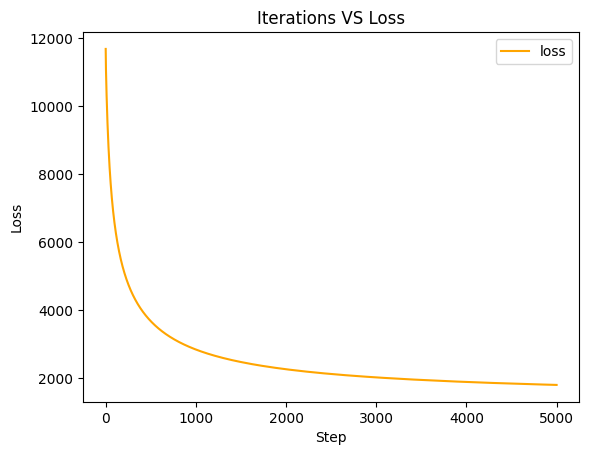

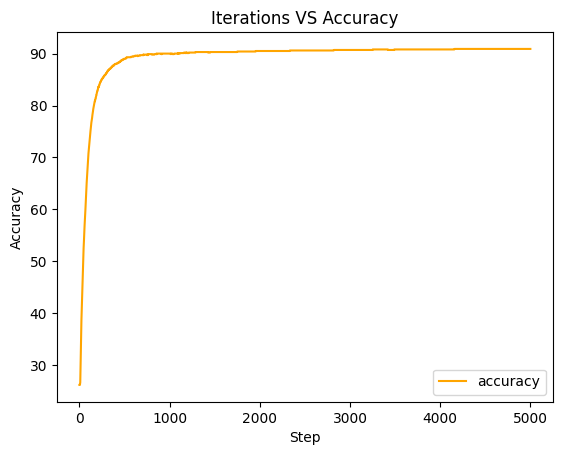

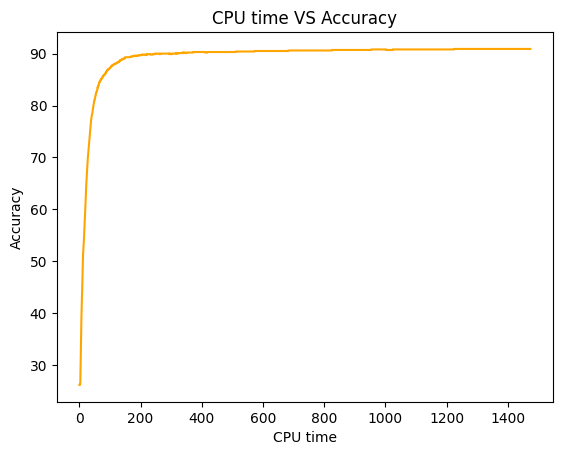

In [ ]:
# Produce plots
args = ["Loss", "Accuracy", "CPU"]
for a in args: model.plot(a)

In [ ]:
# check accuracy on test set
print(f"Accuracy score on test set: {np.round(np.sum(model.predict(X_test) == Y_test) / X_test.shape[0] * 100,2)}")

Accuracy score on test set: 91.11


In [ ]:
# save the data for later comparison
df_gd = model.backup()

## 3) BCGD Randomized

In [ ]:
start_time = time.time()
# fit model
model.fit(X_train, Y_train, type="BCGD_R", alpha=0.0001, max_iter=5000, threshold=100)
end_time = time.time()

print(f"\n Time taken: {np.round(end_time - start_time,2)} seconds")

Streaming output truncated to the last 5000 lines.
Step: 3 ------------ Loss: 12145.23 ------------ Accuracy: 26.2%
Step: 4 ------------ Loss: 12101.33 ------------ Accuracy: 26.2%
Step: 5 ------------ Loss: 12079.41 ------------ Accuracy: 26.2%
Step: 6 ------------ Loss: 12004.84 ------------ Accuracy: 26.2%
Step: 7 ------------ Loss: 11971.58 ------------ Accuracy: 26.2%
Step: 8 ------------ Loss: 11970.34 ------------ Accuracy: 26.2%
Step: 9 ------------ Loss: 11933.61 ------------ Accuracy: 26.2%
Step: 10 ------------ Loss: 11891.06 ------------ Accuracy: 26.2%
Step: 11 ------------ Loss: 11888.82 ------------ Accuracy: 26.2%
Step: 12 ------------ Loss: 11855.04 ------------ Accuracy: 26.2%
Step: 13 ------------ Loss: 11811.05 ------------ Accuracy: 26.2%
Step: 14 ------------ Loss: 11765.72 ------------ Accuracy: 26.2%
Step: 15 ------------ Loss: 11722.69 ------------ Accuracy: 26.2%
Step: 16 ------------ Loss: 11700.35 ------------ Accuracy: 26.2%
Step: 17 ------------ Loss: 1169

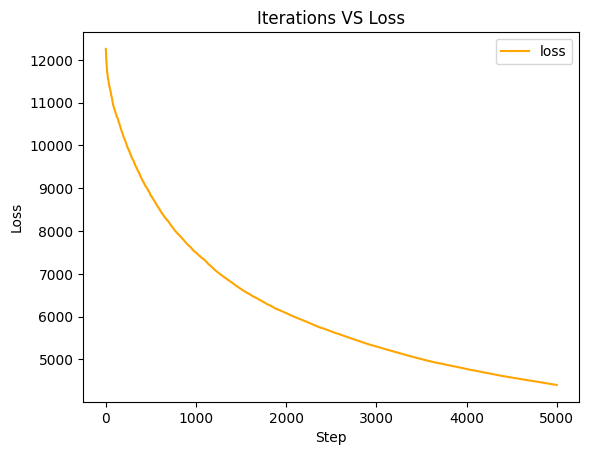

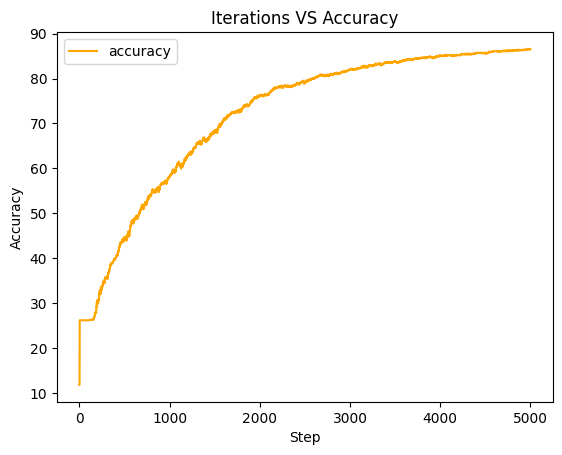

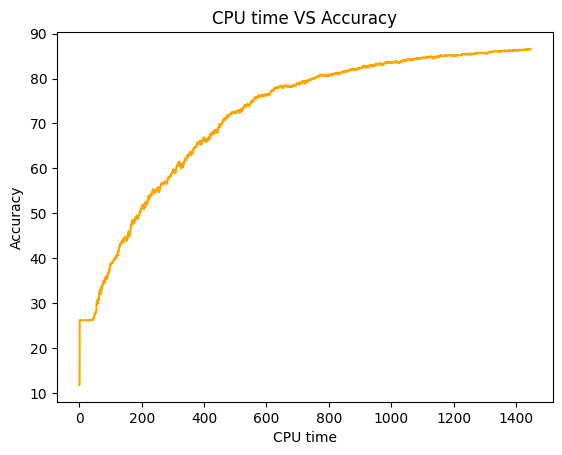

In [ ]:
# Produce plots
args = ["Loss", "Accuracy", "CPU"]
for a in args: model.plot(a)

In [ ]:
# check accuracy on test set
print(f"Accuracy score on test set: {np.round(np.sum(model.predict(X_test) == Y_test) / X_test.shape[0] * 100,2)}")

Accuracy score on test set: 87.15


In [ ]:
# save the data for later comparison
df_random = model.backup()

## 4) BCGD GS Rule

In [ ]:
start_time = time.time()
# fit model
model.fit(X_train, Y_train, type="BCGD_GS", alpha=0.0001, max_iter=5000, threshold=100)
end_time = time.time()

print(f"\n Time taken: {np.round(end_time - start_time,2)} seconds")

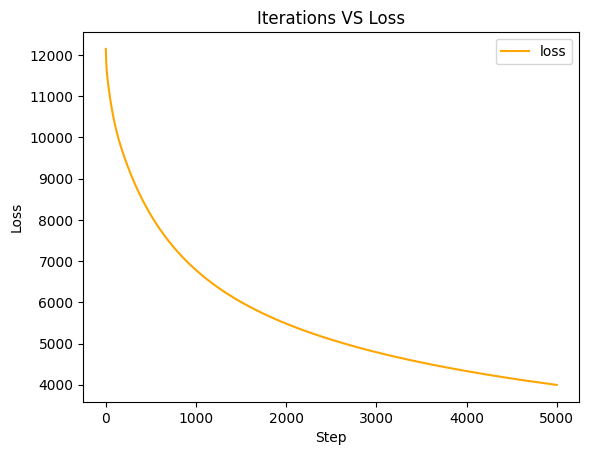

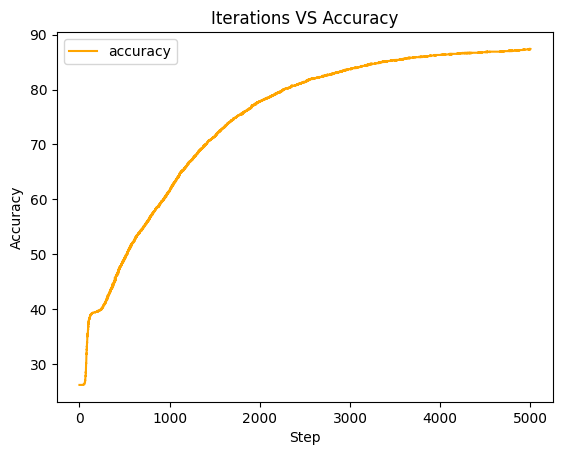

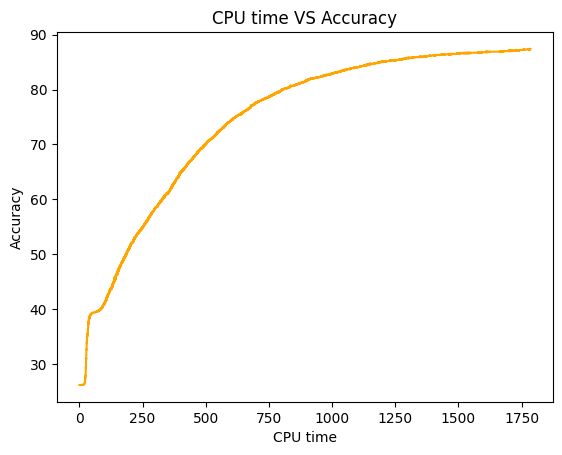

In [ ]:
# Produce plots
args = ["Loss", "Accuracy", "CPU"]
for a in args: model.plot(a)

In [ ]:
# check accuracy on test set
print(f"Accuracy score on test set: {np.round(np.sum(model.predict(X_test) == Y_test) / X_test.shape[0] * 100,2)}")

Accuracy score on test set: 88.56


In [ ]:
# save the data for later comparison
df_gs = model.backup()

## 5) Final Comparision

In [ ]:
plt.figure(figsize=(10, 6))

plt.plot(df_gd['step'], df_gd['loss'], label='Classic GD')
plt.plot(df_random['step'], df_random['loss'], label='BCGD Randomized')
plt.plot(df_gs['step'], df_gs['loss'], label='BCGD GS')

plt.title('Loss comparison ')
plt.xlabel('Iterations')
plt.ylabel('Loss')

plt.legend()
plt.show()

# **2° Real Dataset**

(https://www.kaggle.com/datasets/sayansh001/microbes-dataset)

The dataset consists of 30,527 observations, each detailing 26 features related to microorganisms, which are to be classified into various microbe classes.


## 1) Data Manipulation

In [ ]:
df = pd.read_csv("microbes.csv")
df.head()

In [ ]:
df.shape

In [ ]:
# shuffle rows to prevent imbalanced splitting
df = df.sample(frac=1).reset_index(drop=True)
df['microorganisms']

In [ ]:
# reduce the dataset size
df = df[:20000]

In [ ]:
print(f"Q: Do we have any missing value in the train set? A: {df.isna().any().any()}")

In [ ]:
# drop first column since it's useless
del df['Unnamed: 0']
df.columns

In [ ]:
# labels (#10)
labels = df['microorganisms'].unique().tolist()
labels

In [ ]:
# check if dataset is balanced
df['microorganisms'].value_counts() # frequencies

In [ ]:
# make labels as numbers
Y = df["microorganisms"]

# Step 1: Create a mapping of each unique word to a unique number
word_to_number = {word: index for index, word in enumerate(labels)}

# Step 2: Replace each word in the original list with its corresponding number
Y_as_number = [word_to_number[word] for word in Y]

Y = np.asarray(Y_as_number)
print(Y[:12])

In [ ]:
word_to_number

In [ ]:
# takes al columns but last one (class)
X = df.iloc[:, :-1]

X.tail() #(8000, 16)

In [ ]:
# min-max scaler to avoid overflow issues
X = (X-X.min())/(X.max()-X.min())
print(X.dtypes)

In [ ]:
# Split into train (80%) and test set (20%)
X_train, X_test, Y_train, Y_test = train_test_split(
     X, Y, test_size=0.20, random_state=123)

In [ ]:
# convert dataset into numpy array
X_train = X_train.to_numpy()
X_test = X_test.to_numpy()

## 2) Gradient Descent

In [ ]:
start_time = time.time()
# fit model
model.fit(X_train, Y_train, type="GD", alpha=0.0001, max_iter=5000, threshold=100)
end_time = time.time()

print(f"\n Time taken: {np.round(end_time - start_time,2)} seconds")

Output streaming troncato alle ultime 5000 righe.
Step: 3 ------------ Loss: 12149.13 ------------ Accuracy: 35.5%
Step: 4 ------------ Loss: 12030.13 ------------ Accuracy: 41.1%
Step: 5 ------------ Loss: 11919.06 ------------ Accuracy: 44.0%
Step: 6 ------------ Loss: 11814.91 ------------ Accuracy: 47.3%
Step: 7 ------------ Loss: 11716.99 ------------ Accuracy: 49.5%
Step: 8 ------------ Loss: 11624.75 ------------ Accuracy: 50.5%
Step: 9 ------------ Loss: 11537.7 ------------ Accuracy: 51.4%
Step: 10 ------------ Loss: 11455.41 ------------ Accuracy: 52.1%
Step: 11 ------------ Loss: 11377.49 ------------ Accuracy: 52.6%
Step: 12 ------------ Loss: 11303.6 ------------ Accuracy: 52.6%
Step: 13 ------------ Loss: 11233.44 ------------ Accuracy: 52.7%
Step: 14 ------------ Loss: 11166.71 ------------ Accuracy: 53.0%
Step: 15 ------------ Loss: 11103.16 ------------ Accuracy: 52.9%
Step: 16 ------------ Loss: 11042.57 ------------ Accuracy: 53.1%
Step: 17 ------------ Loss: 10984.7

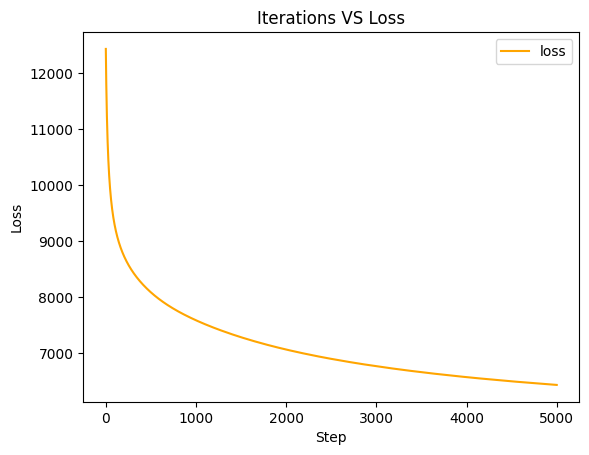

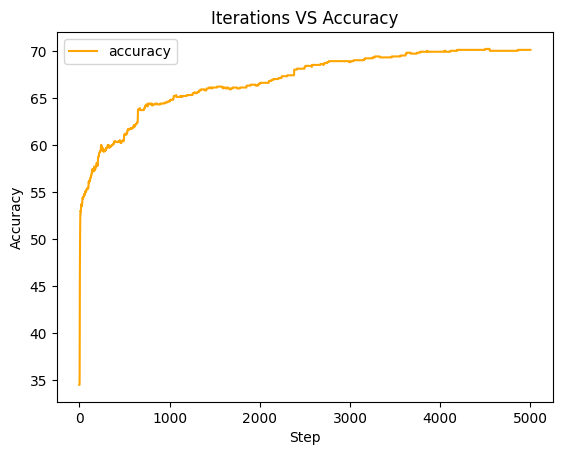

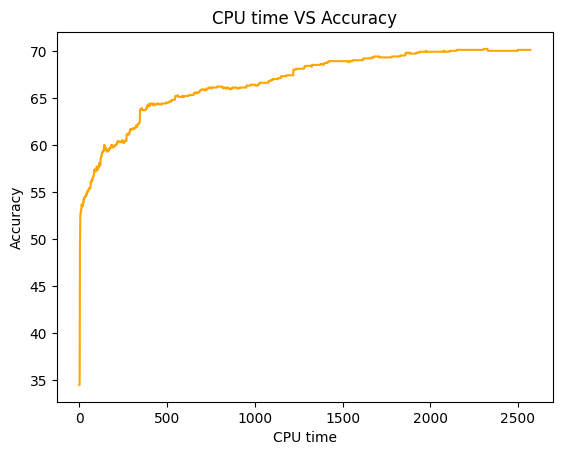

In [ ]:
# Produce plots
args = ["Loss", "Accuracy", "CPU"]
for a in args: model.plot(a)

In [ ]:
# check accuracy on test set
print(f"Accuracy score on test set: {np.round(np.sum(model.predict(X_test) == Y_test) / X_test.shape[0] * 100,2)}")

Accuracy score on test set: 69.04


In [ ]:
# save the data for later comparison
df_gd = model.backup()

## 3) BCGD Randomized

In [ ]:
start_time = time.time()
# fit model
model.fit(X_train, Y_train, type="BCGD_R", alpha=0.0001, max_iter=5000, threshold=100)
end_time = time.time()

print(f"\n Time taken: {np.round(end_time - start_time,2)} seconds")

Streaming output truncated to the last 5000 lines.
Step: 3 ------------ Loss: 13239.67 ------------ Accuracy: 34.9%
Step: 4 ------------ Loss: 13236.19 ------------ Accuracy: 35.5%
Step: 5 ------------ Loss: 13230.28 ------------ Accuracy: 35.6%
Step: 6 ------------ Loss: 13224.71 ------------ Accuracy: 35.4%
Step: 7 ------------ Loss: 13036.34 ------------ Accuracy: 34.5%
Step: 8 ------------ Loss: 13008.68 ------------ Accuracy: 34.5%
Step: 9 ------------ Loss: 12961.85 ------------ Accuracy: 34.5%
Step: 10 ------------ Loss: 12960.19 ------------ Accuracy: 34.5%
Step: 11 ------------ Loss: 12917.58 ------------ Accuracy: 34.5%
Step: 12 ------------ Loss: 12880.39 ------------ Accuracy: 34.5%
Step: 13 ------------ Loss: 12817.29 ------------ Accuracy: 34.5%
Step: 14 ------------ Loss: 12814.55 ------------ Accuracy: 34.5%
Step: 15 ------------ Loss: 12799.07 ------------ Accuracy: 34.5%
Step: 16 ------------ Loss: 12783.89 ------------ Accuracy: 34.5%
Step: 17 ------------ Loss: 1275

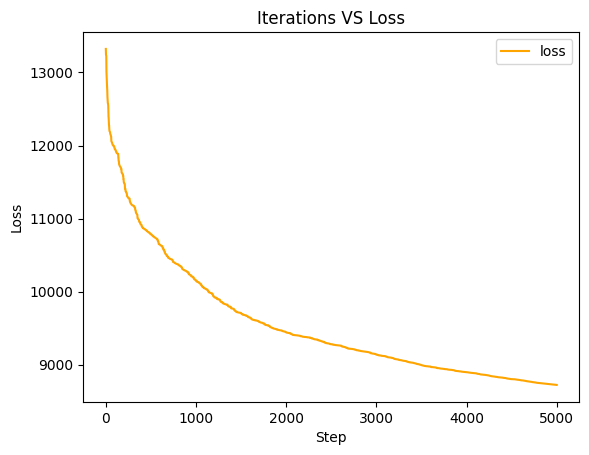

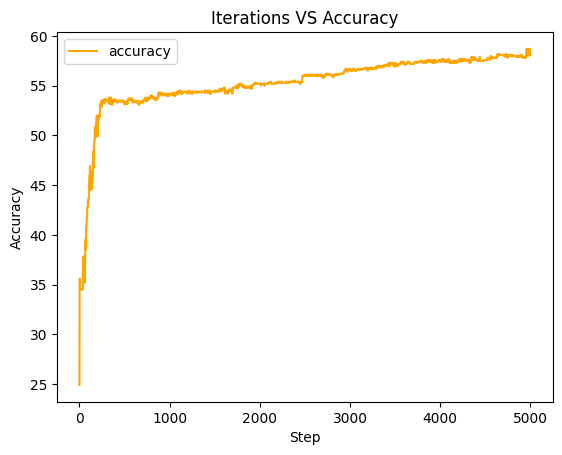

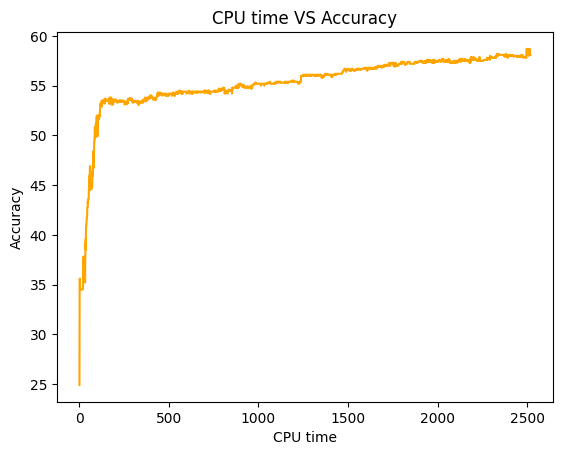

In [ ]:
# Produce plots
args = ["Loss", "Accuracy", "CPU"]
for a in args: model.plot(a)

In [ ]:
# check accuracy on test set
print(f"Accuracy score on test set: {np.round(np.sum(model.predict(X_test) == Y_test) / X_test.shape[0] * 100,2)}")

Accuracy score on test set: 55.29


In [ ]:
# save the data for later comparison
df_random = model.backup()

## 4) BCGD GS Rule

In [ ]:
start_time = time.time()
# fit model
model.fit(X_train, Y_train, type="BCGD_GS", alpha=0.0001, max_iter=5000, threshold=100)
end_time = time.time()

print(f"\n Time taken: {np.round(end_time - start_time,2)} seconds")

Output streaming troncato alle ultime 5000 righe.
Step: 3 ------------ Loss: 12892.02 ------------ Accuracy: 34.5%
Step: 4 ------------ Loss: 12804.13 ------------ Accuracy: 34.5%
Step: 5 ------------ Loss: 12724.26 ------------ Accuracy: 34.5%
Step: 6 ------------ Loss: 12651.73 ------------ Accuracy: 34.5%
Step: 7 ------------ Loss: 12588.05 ------------ Accuracy: 34.5%
Step: 8 ------------ Loss: 12526.22 ------------ Accuracy: 34.5%
Step: 9 ------------ Loss: 12470.18 ------------ Accuracy: 34.5%
Step: 10 ------------ Loss: 12418.73 ------------ Accuracy: 34.5%
Step: 11 ------------ Loss: 12367.61 ------------ Accuracy: 34.5%
Step: 12 ------------ Loss: 12320.11 ------------ Accuracy: 34.5%
Step: 13 ------------ Loss: 12273.26 ------------ Accuracy: 34.5%
Step: 14 ------------ Loss: 12229.23 ------------ Accuracy: 34.5%
Step: 15 ------------ Loss: 12186.09 ------------ Accuracy: 34.5%
Step: 16 ------------ Loss: 12145.12 ------------ Accuracy: 34.5%
Step: 17 ------------ Loss: 12105

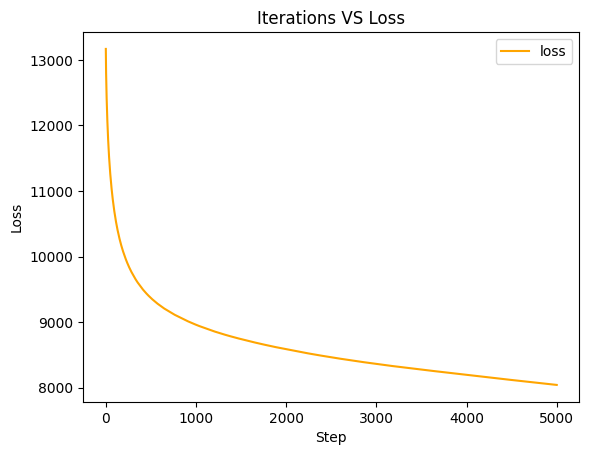

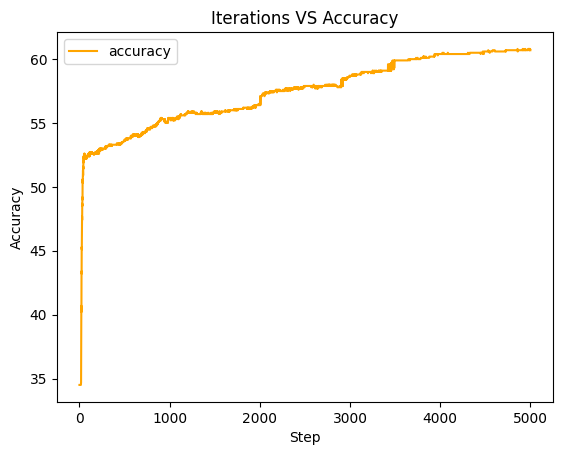

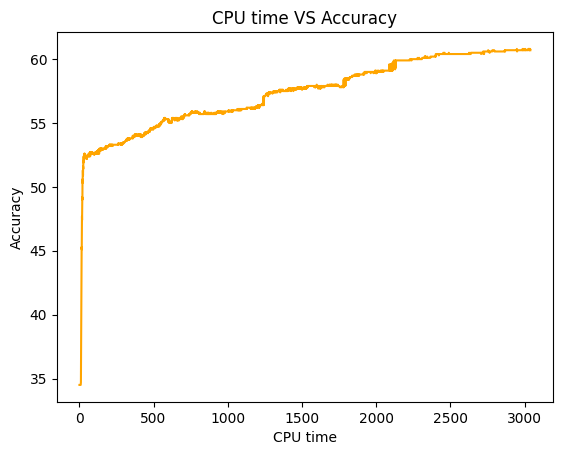

In [ ]:
# Produce plots
args = ["Loss", "Accuracy", "CPU"]
for a in args: model.plot(a)

In [ ]:
# check accuracy on test set
print(f"Accuracy score on test set: {np.round(np.sum(model.predict(X_test) == Y_test) / X_test.shape[0] * 100,2)}")

Accuracy score on test set: 57.84


In [ ]:
# save the data for later comparison
df_gs = model.backup()

## 5) Final Comparision

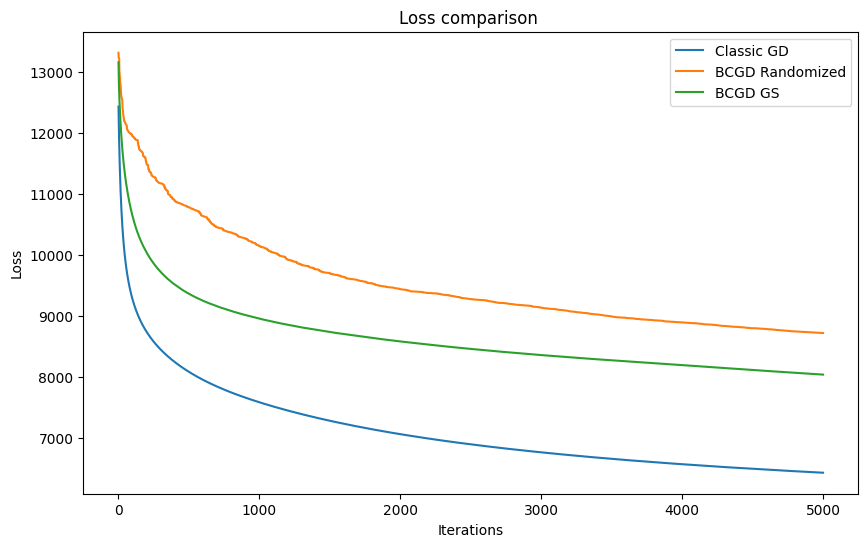

In [ ]:
plt.figure(figsize=(10, 6))

plt.plot(df_gd['step'], df_gd['loss'], label='Classic GD')
plt.plot(df_random['step'], df_random['loss'], label='BCGD Randomized')
plt.plot(df_gs['step'], df_gs['loss'], label='BCGD GS')

plt.title('Loss comparison ')
plt.xlabel('Iterations')
plt.ylabel('Loss')

plt.legend()
plt.show()